# Predicting Activity with an LSTM
i.e., full dataset, transformed to PCA

In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 66
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

Using Theano backend.


In [2]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7558]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7558]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
print X_train.shape #(4472, 7555)
print Y_test.shape #(1044, )
print dummy_y_test.shape # (1044, 5)


(4472, 7555)
(1044,)
(1044, 5)


In [3]:
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

from sklearn import decomposition

pca = decomposition.PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 100 components:'
print sum(pca.explained_variance_ratio_)

Variance explained:
[ 0.19505564  0.08295663  0.04067402  0.02174272  0.01775119  0.01686748
  0.01440615  0.01150575  0.01055     0.00958828  0.00877439  0.00790115
  0.007298    0.00704889  0.0066142   0.00595329  0.00538577  0.00530285
  0.00491633  0.0045751   0.00440203  0.00436509  0.00395662  0.00343414
  0.00340722  0.00328142  0.00325585  0.00305899  0.00297009  0.00289683
  0.00281987  0.00273652  0.00266189  0.00265268  0.00260069  0.0024912
  0.00238337  0.00232648  0.00226495  0.00224082  0.00221907  0.00217391
  0.00215321  0.00208428  0.00204535  0.00198475  0.00192726  0.00190714
  0.00187787  0.00183914  0.00176811  0.00173735  0.00169542  0.00166308
  0.00165403  0.00162881  0.00161277  0.0015787   0.00157364  0.00155227
  0.0015123   0.00149719  0.00148685  0.00147954  0.00145035  0.00142099
  0.00141436  0.00141164  0.00138952  0.00136064  0.00134219  0.0013185
  0.00130973  0.00129871  0.00129763  0.0012655   0.00125215  0.00124378
  0.00122832  0.0012048   0.00119

In [21]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.constraints import maxnorm
from keras.optimizers import SGD

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=7555, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(20, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout_decay():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_deeper_dropout_decay_PCA():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(100,)))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.8, decay=0.0001, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def create_LSTM_PCA(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(20, batch_input_shape=(batch_size, 1, trainShape1), 
                   stateful=True))
    model.add(Dense(5, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM2_PCA(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM2_PCA()
print model.summary()

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))
print trainX.shape




____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lstm_12 (LSTM)                     (1, 1, 200)         240800      lstm_input_5[0][0]               
____________________________________________________________________________________________________
dropout_16 (Dropout)               (1, 1, 200)         0           lstm_12[0][0]                    
____________________________________________________________________________________________________
lstm_13 (LSTM)                     (1, 1, 100)         120400      dropout_16[0][0]                 
____________________________________________________________________________________________________
dropout_17 (Dropout)               (1, 1, 100)         0           lstm_13[0][0]                    
___________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model--3lstm.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights--3lstm.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


def printValStats(model, testX, dummy_y_test):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)


# Fit the model
batch_size = 1
nb_epochs = 200
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train, validation_data=(testX,dummy_y_test), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=1, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])

    model.reset_states()
    # Estimate model performance, and reset states!
    testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                                verbose=0)
    model.reset_states()
    print 'Test score after epoch of whole dataset:'
    print testScore
    printValStats(model, testX, dummy_y_test)

# Estimate model performance, and reset states!
testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                            verbose=0)
model.reset_states()
print 'Final Test score:'
print testScore

#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/




('Epoch', 1, '/', 200)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 82s - loss: 1.3379 - acc: 0.4776 - val_loss: 1.6138 - val_acc: 0.3151
Test score after epoch of whole dataset:
[1.6205890217788832, 0.31417624521072796]
Performance of model on test set ----------------------------
Accuracy:
0.314176245211
Confusion matrix:
[[  0 200   0   0   0]
 [  0 325   0   0   0]
 [ 15 318   3   0   1]
 [ 26  69   0   0   0]
 [  0  87   0   0   0]]
AUC score:
0.66674515947
('Epoch', 2, '/', 200)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 87s - loss: 1.2323 - acc: 0.5065 - val_loss: 2.4383 - val_acc: 0.1322
Test score after epoch of whole dataset:
[2.4451858868886687, 0.13026819923371646]
Performance of model on test set ----------------------------
Accuracy:
0.130268199234
Confusion matrix:
[[  0 195   5   0   0]
 [  0  54 271   0   0]
 [  0 244  82   0  11]
 [  0  84  11   0   0]

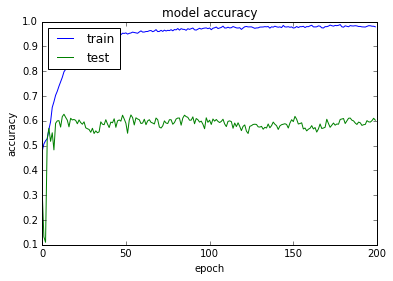

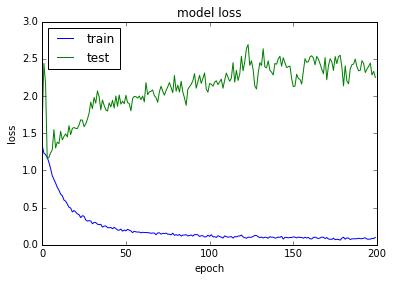

In [23]:
# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [25]:
max(val_accs)

0.62643678160919536